In [3]:
from SimPEG import *
from simpegAIP.FD import AFEMIPProblem_b
from SimPEG import EM
from pymatsolver import MumpsSolver
from scipy.constants import mu_0
from simpegAIP.FD import ColeColePropMap
from simpegAIP.FD.Utils import hzAnalyticDipoleF_CC, hzAnalyticCentLoopF_CC
from scipy.constants import mu_0
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [4]:
from simpegAIP.FD.Utils import ColeColePelton

In [5]:
cs, ncx, ncz, npad = 10, 25, 20, 20
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sighalf = 1e-3
siginf = np.ones(mesh.nC)*1e-8
siginf[mesh.gridCC[:,-1]<0.] = sighalf
eta = np.ones(mesh.nC)*0.1
tau = np.ones(mesh.nC)*0.001
c = np.ones(mesh.nC)*0.7
m = np.r_[siginf, eta, tau, c]
# m0 = np.r_[siginf, eta*0., tau, c]
# mapping = ColeColeMap(mesh)

In [6]:
from simpegAIP.FD.Utils import ColeColePelton, ColeColeSeigel

In [18]:
offset = 0.
frequency = np.logspace(1, 4, 41)
rx0 = EM.FDEM.Rx(np.array([[0., 0., 0.]]), 'bzr_sec')
rx1 = EM.FDEM.Rx(np.array([[0., 0., 0.]]), 'bzi_sec')
srcLists = []
nfreq = frequency.size
for ifreq in range(nfreq):
    src = EM.FDEM.Src.CircularLoop([rx0, rx1], frequency[ifreq], np.array([[0., 0., 0.]]), radius=13.)
    srcLists.append(src)
survey = EM.FDEM.Survey(srcLists)
# sigmaBase = runPrevInv()
# maps = [('eta', iMap), ('tau', iMap), ('c', iMap)]
maps = [('sigmaInf', iMap), ('eta', iMap), ('tau', iMap), ('c', iMap)]
# mapping = {'maps':maps, 'slices':{}, 'defaults':{"sigmaInf":sigmaBase}}
prob = AFEMIPProblem_b(mesh, mapping=maps)
iMap = Maps.IdentityMap(nP=int(mesh.nC))

# prob.setPropMap(mapsdict)
prob.Solver = MumpsSolver
survey.pair(prob)

In [21]:
obs = survey.dpred(m)
OBS = obs.reshape((nfreq, 2))

In [22]:
bza = mu_0*hzAnalyticCentLoopF_CC(src.radius, frequency, sigmaInf=sighalf, eta=eta[0], tau=tau[0], c=c[0])
bzem = mu_0*hzAnalyticCentLoopF_CC(src.radius, frequency, sigmaInf=sighalf, eta=eta[0]*0., tau=tau[0], c=c[0])

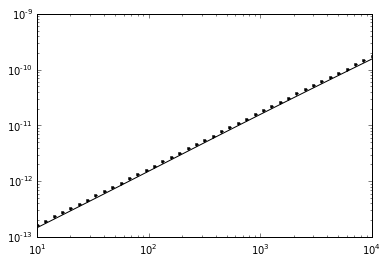

In [23]:
# plt.loglog(frequency, -bza.real)
plt.loglog(frequency, abs(bza.imag), 'k')
plt.loglog(frequency, abs(OBS[:,1]), 'k.')

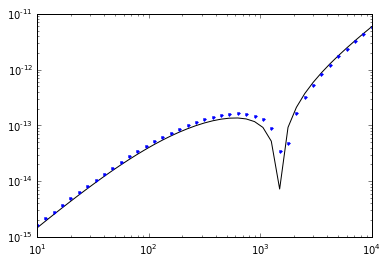

In [24]:
plt.loglog(frequency, abs(bza.real), 'k-')
plt.loglog(frequency, abs(OBS[:,0]), '.')